#Convolutional neural network

###import library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob
#Le module glob recherche tous les chemins correspondant à un motif 
#particulier selon les règles utilisées par le shell Unix, les résultats sont renvoyés dans un ordre arbitraire.

import librosa
import librosa.display
import IPython.display as ipd

from tqdm import tqdm
import os

###Création mel spectrogramme pour chaque fichier audio

In [ ]:
feature_list = []
label_list = []
dictMel = {}
# Iterate over all files in given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('.')):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('.', file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    if mels_db.shape == (128,87):
      feature_list.append(mels_db.reshape((128, 87, 1)))
      filename = int(str(file)[:-4])
      label_list.append(filename)
      dictMel[filename] = mels_db
features = np.array(feature_list)
labels = np.array(label_list)

Preparing feature dataset and labels.


 31%|███       | 93/303 [00:03<00:07, 27.41it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2000
  n_fft, y.shape[-1]
100%|██████████| 303/303 [00:11<00:00, 26.32it/s]


In [ ]:
features.shape

(292, 128, 87, 1)

In [ ]:
labels.shape

(292,)

###Tri des élements par ordre de nom de fichier

In [ ]:
dataMel = pd.Series(dictMel)
dataMel=dataMel.sort_index()
listMel =dataMel.to_list()
liste_son=dataMel.index.to_list()

###On converti en matrice 3D

In [ ]:
def list_to_matrix(X):
  matrix = np.zeros(shape=(len(X),128, 87))
  for i in range(len(X)):
    if X[i].shape == (128, 87):
      #print(X[i].shape, ' son num : ',i)
      matrix[i]=X[i]
  return matrix

matrix = list_to_matrix(listMel)

###Récupération des labels

In [ ]:
datacomp=pd.read_csv("Labels3files.csv",sep=";")

In [ ]:
datacomp['nomSon']=datacomp['nomSon'].str.replace(r"[-;]", '',regex =True).astype(int)
datacomp.head()

,Moyenne,Mediane,nomSon
0,"1,143",1,0
1,0,0,57
2,"0,857",2,94
3,"0,714",1,110
4,"1,571",2,135


In [ ]:
datacomp=datacomp[datacomp['nomSon'].isin(liste_son)]

In [ ]:
datacomp

,Moyenne,Mediane,nomSon
0,"1,143",1,0
1,0,0,57
2,"0,857",2,94
3,"0,714",1,110
4,"1,571",2,135
...,...,...,...
294,"0,714285714",1,13572
295,"0,285714286",0,13644
296,"-1,714285714",-2,13674
297,"0,571428571",1,13755


In [ ]:
datacomp['Moyenne ']=datacomp['Moyenne '].str.replace(',','.')
datacomp['Moyenne ']=datacomp['Moyenne '].astype(float)
datacomp.rename(columns = {'Moyenne ':'Moyenne'}, inplace = True)

On crée la target 

In [ ]:
datacomp.Moyenne = [0 if i<-1.2 else 1 if i<-0.4 else 2 if i<0.4 else 3 if i<1.2 else 4 for i in datacomp.Moyenne]
datacomp['MedianeBin'] = [0 if i<1 else 1 for i in datacomp.Mediane]
datacomp.Mediane = [0 if i==-2 else 1 if i==-1 else 2 if i==0 else 3 if i==1 else 4 for i in datacomp.Mediane]
#on adapte nos labels pour notre classification

In [ ]:
datacomp['Mediane'].count()

292

In [ ]:
datacomp.Mediane.value_counts()
#on observe déja un déséquilibre dans les classes

3    88
4    81
1    50
2    40
0    33
Name: Mediane, dtype: int64

### Préparation des données pour le réseau de neuronnes

In [ ]:
X_train_full = matrix
y_train_full = datacomp[['MedianeBin']]
#on peut changer la métrique de notre label en choisissant La moyenne ou la médiane
#y_train_full = datacomp[['Moyenne']]

In [ ]:
# X_train, y_train = X_train_full[:240],y_train_full[:240]
# X_test, y_test = X_train_full[240:],y_train_full[240:]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2,random_state=123)

In [ ]:
print(X_test.shape)
print(y_test.shape)

(59, 128, 87)
(59, 1)


###Constuire un model avec tf.keras.sequential

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(1, activation=keras.activations.sigmoid)
    ])
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 87, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 43, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 43, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 21, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 21504)             0         
                                                                 
 dropout (Dropout)           (None, 21504)             0

Epoch 1/20
8/8 [==============================] - 2s 167ms/step - loss: 21.2656 - accuracy: 0.5323 - val_loss: 14.9813 - val_accuracy: 0.5106
Epoch 2/20
8/8 [==============================] - 1s 129ms/step - loss: 4.4930 - accuracy: 0.6720 - val_loss: 2.8970 - val_accuracy: 0.6383
Epoch 3/20
8/8 [==============================] - 1s 140ms/step - loss: 1.6918 - accuracy: 0.8065 - val_loss: 1.4674 - val_accuracy: 0.7660
Epoch 4/20
8/8 [==============================] - 1s 141ms/step - loss: 0.6366 - accuracy: 0.8871 - val_loss: 1.0265 - val_accuracy: 0.7660
Epoch 5/20
8/8 [==============================] - 1s 137ms/step - loss: 0.2407 - accuracy: 0.9355 - val_loss: 0.8562 - val_accuracy: 0.7872
Epoch 6/20
8/8 [==============================] - 1s 131ms/step - loss: 0.1768 - accuracy: 0.9194 - val_loss: 0.7244 - val_accuracy: 0.7447
Epoch 7/20
8/8 [==============================] - 1s 131ms/step - loss: 0.0794 - accuracy: 0.9839 - val_loss: 0.7441 - val_accuracy: 0.7447
Epoch 8/20
8/8 [==

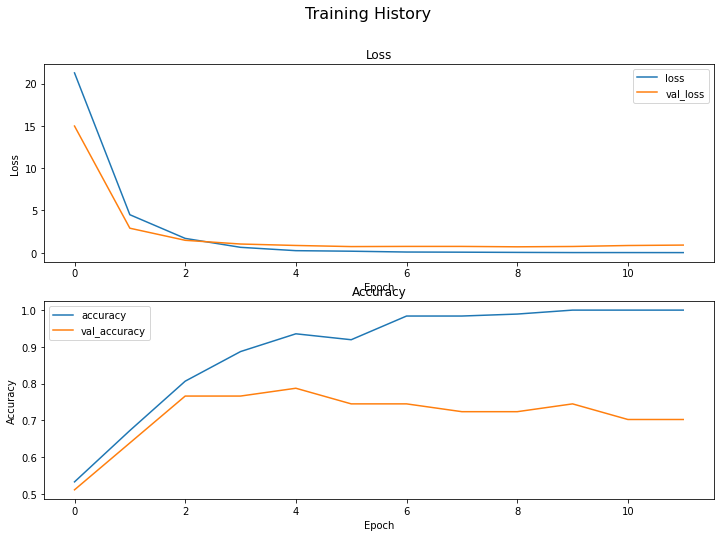

In [ ]:
# Set parameters for data splitting and training
TEST_SIZE = 0.2
BATCH_SIZE = 25
EPOCHS = 20

# Encode Labels
#encoded_labels = tf.one_hot(indices=labels, depth=10)
# Split dataset to train and test data
#X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()